In [1530]:
import torch
import torch.nn as nn
from torch.distributions import Normal, MixtureSameFamily, Categorical, Dirichlet, Independent

In [1531]:
from src.environment import NormalMoveEnv
from src.experiment import Trajectory

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

<AxesSubplot: >

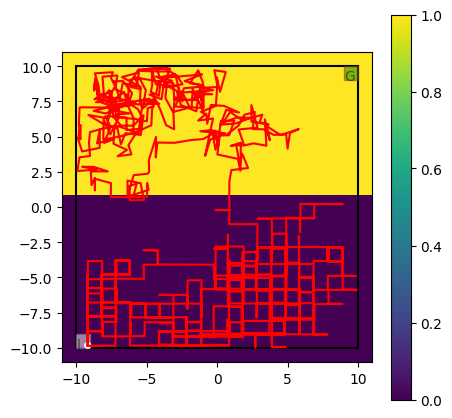

In [1532]:
env_params = {
    'walls': [],
    'goals': [([9.,9.],[10.,10.])],
    'start': ([-10.,-10.],[-9.,-9.]),
}

# sigma=(.01, .3), 
# tau=(1., -1.), 

env = NormalMoveEnv(**env_params)

s = env.reset()

t = Trajectory(env, size=1_000)
ax = t.plot(env.plot())
ax

In [1533]:
t.run

,step,s,a,r,s_,end
0,1.0,"[-9.184843527499048, -9.817924923329851]",2.0,1.0,"[-9.194583, -8.821802]",0.0
0,2.0,"[-9.194583, -8.821802]",0.0,1.0,"[-8.189321, -8.810626]",0.0
0,3.0,"[-8.189321, -8.810626]",1.0,1.0,"[-9.1916485, -8.79985]",0.0
0,4.0,"[-9.1916485, -8.79985]",2.0,1.0,"[-9.203451, -7.8050613]",0.0
0,5.0,"[-9.203451, -7.8050613]",2.0,1.0,"[-9.197036, -6.781084]",0.0
...,...,...,...,...,...,...
0,996.0,"[-4.1506767, 8.943143]",1.0,1.0,"[-3.1216, 8.801603]",0.0
0,997.0,"[-3.1216, 8.801603]",2.0,1.0,"[-3.029252, 7.6279154]",0.0
0,998.0,"[-3.029252, 7.6279154]",1.0,1.0,"[-1.4932, 7.5852733]",0.0
0,999.0,"[-1.4932, 7.5852733]",3.0,1.0,"[-1.7313759, 8.421636]",0.0


<AxesSubplot: >

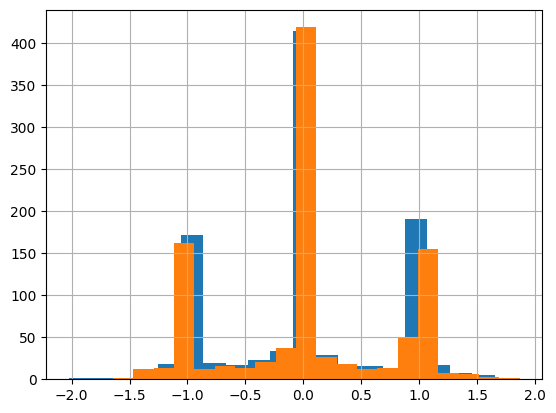

In [1534]:
dist = t.run.copy()
## dist['move'] = np.linalg.norm(np.stack(t.run.s_.values) - np.stack(t.run.s.values), axis=1)
dist['move_id'] = np.sum(np.stack(t.run.s_.values) - np.stack(t.run.s.values), axis=1)
dist['move'] = t.run.s_.values - t.run.s.values
dist['move_x'] = np.stack(t.run.s_.values)[:,0] - np.stack(t.run.s.values)[:,0]
dist['move_y'] = np.stack(t.run.s_.values)[:,1] - np.stack(t.run.s.values)[:,1]
# dist.move_id.hist(bins=20)
dist.move_x.hist(bins=20)
dist.move_y.hist(bins=20)

# Mixture of Gaussianas

$ x \sim N(\mu, \Sigma)$ 

$ z \sim Categorical(k, \phi) \; where \; \phi_j>=0, and \sum_{j=1}^k{\phi_j} = 1 $ 

$l(\phi, \mu, \Sigma) = \sum_{i=1}^m{log \; p(x^{(i)}|z^{(i)};\mu,\Sigma) + log \; p(z^{(i)}; \phi)}$


In [1248]:
# k = 5

# mix = Categorical(torch.ones(k))
# comp = Normal(torch.randn(k), torch.exp(torch.randn(k)))
# gmm = MixtureSameFamily(mix, comp)
# # torch.exp(gmm.log_prob(X))
# probs = torch.exp(gmm.component_distribution.log_prob(torch.tensor(dist.move.to_numpy()).reshape(-1,1)))
# torch.sum(probs, axis=0)

In [1535]:
d = 2 # Dimensions 
k = 5 # N of Gasussians

mix = Categorical(torch.ones(k))
comp = Independent(Normal(torch.randn(k).reshape(-1,1).repeat(1,d), torch.exp(torch.randn(k).reshape(-1,1).repeat(1,d))), 1)
gmm = MixtureSameFamily(mix, comp)

probs = torch.exp(gmm.component_distribution.log_prob(torch.tensor(np.stack(dist.move.values)).reshape((-1,1,d))))
torch.sum(probs, axis=0)


tensor([133.4964,   6.3912,  70.0480, 121.2902,  50.2707], dtype=torch.float64)

In [1536]:
mix = Categorical(torch.tensor([[.003, .003, .004, .99], [.003, .99, .004, .003], [.003, .003, .99, .004]]))
comp = Independent(
    Normal(
        torch.tensor([
            [[1.,0.], [-1.,0.], [0.,1.], [0.,-1.]],
            [[10.,0.], [-10.,0.], [0.,10.], [0.,-10.]],
            [[100.,0.], [-100.,0.], [0.,100.], [0.,-100.]]
            ]),
        torch.tensor([
            [[.1,.1], [.1,.1], [.1,.1], [.1,.1]],
            [[1.,1.], [1.,1.], [1.,1.], [1.,1.]],
            [[10.,10.], [10.,10.], [10.,10.], [10.,10.]]
        ])
    ), 1
)
gmm = MixtureSameFamily(mix, comp)

s=0
a=3
sample = torch.round(gmm.component_distribution.sample(torch.tensor([10]))[:,s,a], decimals=5)
sample

sample = torch.stack([
    torch.round(gmm.component_distribution.sample(torch.tensor([1]))[:,s,a])[0] for s in range(3)
])

torch.round(torch.exp(gmm.log_prob(sample.reshape((-1,1,d)))), decimals=7)

tensor([[1.5756e+01, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.7560e-04, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.2000e-06]])

# Expectation Maximization

### 1. Expectation

$w_j^{(i)} = p(z^{(i)} = j | x^{(i)}; \phi, \mu, \Sigma ) = \frac{p(x^{(i)}|z^{(i)}=j; \mu,\Sigma) p(z^{(i)}=j;\phi)}{\sum_{l=1}^k{p(x^{(i)}|z^{(i)}=l; \mu, \Sigma)p(z^{(i)}=l;\phi)}}$

### 2. Maximization

$\phi_j = \frac{1}{m}\sum_{i=1}^m{w_j^{(i)}}$  

$\mu_j = \frac{\sum_{i=1}^m{w_j^{(i)}}x^{(i)}}{\sum_{i=1}^m{w_j^{(i)}}}$ 

$\Sigma_j = \frac{\sum_{i=1}^m{w_j^{(i)}(x^{(i)}-\mu_j)^2}}{\sum_{i=1}^m{w_j^{(i)}}}$ 

## 1D

In [1250]:
# from tqdm import tqdm
def expctation_maximization(data, iterations=100, k=3):
    classes = Dirichlet(torch.ones(k)).sample((1,)).flatten()
    mus = torch.rand(k)
    sigmas = torch.rand(k)

    X = torch.tensor(data).reshape(-1,1)
    m = data.shape[0]
    mix = Categorical(classes)
 
    for i in range(iterations):
        comp = Normal(mus, torch.clamp(sigmas, min=1e-5*torch.ones(k)))
        gmm = MixtureSameFamily(mix, comp)
        # Expectation
        comp_dist = gmm.mixture_distribution.probs
        comp_probs = torch.exp(gmm.component_distribution.log_prob(X))
        resps = (comp_dist*comp_probs) / torch.sum(comp_dist*comp_probs, axis=1).reshape((-1,1))
       
        # Maximization
        mix = Categorical((1/m) * torch.sum(resps, axis=0))
        mus = torch.sum(resps*X, axis=0) / torch.sum(resps, axis=0)
        sigmas = torch.sqrt(torch.sum(resps*((X-mus)**2), axis=0) / torch.sum(resps, axis=0))


    return mix.probs, mus, sigmas

expctation_maximization(
    data=dist.move_id.to_numpy(),
    iterations=1000,
    k=3
)

(tensor([0.1980, 0.4166, 0.3853], dtype=torch.float64),
 tensor([-0.0799,  1.0010, -0.9995], dtype=torch.float64),
 tensor([0.8984, 0.0147, 0.0135], dtype=torch.float64))

## n-D

In [1251]:
# from tqdm import tqdm
def expctation_maximization(data, iterations=100, k=3):
    m,d = data.shape
    classes = Dirichlet(torch.ones(k)).sample((1,)).flatten()
    mus = torch.rand((k,d))
    sigmas = torch.rand((k,d))

    # X = torch.tensor(data).reshape(-1,1)
    X = torch.tensor(data).reshape((m,d))
    mix = Categorical(classes)
 
    for i in range(iterations):
        comp = Independent(Normal(mus, torch.clamp(sigmas, min=1e-5*torch.ones((k,d)))), 1)
        gmm = MixtureSameFamily(mix, comp)
        # Expectation
        comp_dist = gmm.mixture_distribution.probs
        comp_probs = torch.exp(gmm.component_distribution.log_prob(X.reshape((m,1,d))))
        w = (comp_dist*comp_probs) / torch.sum(comp_dist*comp_probs, axis=1).reshape((-1,1))
       
        # Maximization
        mix = Categorical((1/m) * torch.sum(w, axis=0))
        for j in range(k):
            mus[j] = torch.sum(w[:,j].reshape(-1,1)*X, axis=0) / torch.sum(w[:,j], axis=0)
            sigmas[j] = torch.sqrt(torch.sum(w[:,j].reshape(-1,1)*((X-mus[j])**2), axis=0) / torch.sum(w[:,j]))

    return mix.probs, mus, sigmas

probs, mus, sigs = expctation_maximization(
    data=np.stack(dist.move.values),
    iterations=5000,
    k=9
)

print('class_probs: ',torch.round(probs, decimals=3))
print('Mus: ', torch.round(mus, decimals=2))
print('Sigmas: ', torch.round(sigs, decimals=2))

class_probs:  tensor([0.0140, 0.2090, 0.0300, 0.2400, 0.0410, 0.0370, 0.0280, 0.1920, 0.2080],
       dtype=torch.float64)
Mus:  tensor([[ 0.5500, -0.0700],
        [ 0.0000,  1.0000],
        [-0.0500,  0.9100],
        [ 0.0000, -0.7900],
        [ 0.0100, -1.0400],
        [-1.0000,  0.0100],
        [ 1.0600, -0.0300],
        [-1.0000,  0.0000],
        [ 1.0000,  0.0000]])
Sigmas:  tensor([[0.0800, 0.9000],
        [0.0100, 0.0100],
        [0.2700, 0.2600],
        [0.0100, 0.4100],
        [0.1900, 0.2800],
        [0.2100, 0.2700],
        [0.1600, 0.3700],
        [0.0100, 0.0100],
        [0.0100, 0.0100]])


# Adaptação para MDP

$ \Delta_t = s_t - s_{t-1}$

$ \phi = f(s_t,a_t | \theta)$

Gaussian Probability Density Function:

$p(\Delta_t|z_t=j; \mu, \Sigma) = \frac{1}{(2\pi)^{d/2}|\Sigma_j|^{1/2}}e^{-\frac{1}{2}(\Delta_t-\mu_j)^T\Sigma_j^{-1}(\Delta_t-\mu_j)}$

E-Step:

$w_t^{j} = p(z_t = j | \Delta_t, s_t, a_t; \mu, \Sigma ) = \frac{p(\Delta_t|z_t=j; \mu^j,\Sigma^j) p(z_t=j;s_t,a_t)}{\sum_{l=1}^k{p(\Delta_t|z_t=l; \mu^l, \Sigma^l)p(z_t=l; s_t,a_t)}} = \frac{p(\Delta_t|z_t=j; \mu^j,\Sigma^j) f(s_t,a_t|\theta)^j}{\sum_{l=1}^k{p(\Delta_t|z_t=l; \mu^l, \Sigma^l)f(s_t,a_t|\theta)^l}}$

M-Step:


$\theta = \theta + \alpha \nabla (\frac{1}{m}\sum_{t=1}^m{w_t\times log(p(\Delta_t|\mu, \Sigma))})$  
<!-- $\phi = \frac{1}{m}\sum_{t=1}^m{w_t}$   -->

$\mu^j = \frac{\sum_{t=1}^m{w_t^j}\Delta_t}{\sum_{t=1}^m{w_t^j}}$ 

$\Sigma^j = \frac{\sum_{t=1}^m{w_t^j(\Delta_t-\mu_j)^2}}{\sum_{t=1}^m{w_t^j}}$ 

In [1330]:

X = np.array([1., 0., -1.])
x_ = np.array([1.1, .05, -.8])

z = (X - x_)**2

d = np.std(z)**2

# np.e**-(1/(2*d) * z**2) / np.sum(np.e**-(1/(2*d) * z**2))
np.round((np.e**-(1/(2*d) * z) / np.sum(np.e**-(1/(2*d) * z))), decimals=3)

array([0., 1., 0.])

In [1545]:
# def expctation_maximization(s, a, s_, iterations=100, k=3, lr=1e-4, momentum=.9):
#     data = s_-s
#     m,d = data.shape
#     s,a = torch.tensor(s), torch.tensor(a)
#     ad = a.unique().shape[0]
    
#     phi = torch.rand(k, ad).type(torch.DoubleTensor)
#     # mask  = 

#     mus = torch.rand(k, ad, d).type(torch.DoubleTensor)
#     sigmas = torch.exp(torch.rand(k, ad, d)).type(torch.DoubleTensor)
    
#     X = torch.tensor(data).reshape((m,d)).type(torch.DoubleTensor)

#     for i in range(iterations):
#         # print(i)

#         mix = Categorical(phi)
#         comp = Independent(
#             Normal(
#                 torch.nan_to_num(mus), 
#                 torch.clamp(torch.nan_to_num(sigmas), min=1e-5*torch.ones(sigmas.shape))
#             ), 1)
        
#         gmm = MixtureSameFamily(mix, comp)
#         log_probs = gmm.component_distribution.log_prob(X.reshape((-1,1,1,d)))

#         # Expectation
#         comp_dist = gmm.mixture_distribution.probs
#         comp_probs = torch.exp(log_probs)

#         W = torch.clamp((comp_probs * comp_dist) / (comp_probs*comp_dist).sum(axis=0), min=1e-5)
       
#         phi = (1/m) * torch.sum(W, axis=0)
#         mus = torch.sum(W.reshape(-1,k,ad,1)*X.reshape(-1,1,1,d), axis=0) / torch.sum(W, axis=0).reshape(k,ad,1)
#         sigmas = torch.sqrt(torch.sum(W.reshape(-1,k,ad,1)*(X.reshape(-1,1,1,d) - mus)**2, axis=0)) / torch.sum(W, axis=0).reshape(k,ad,1)

#     return phi, mus, sigmas



# probs, mus, sigs = expctation_maximization(
#     s=np.stack(dist.s.values),
#     a=dist.a.values,
#     s_=np.stack(dist.s_.values),
#     iterations=100,
#     k=9
# )

# print('ok')
# # print('class_probs: ',torch.round(probs, decimals=2))
# # print('Mus: ', torch.round(mus, decimals=2))
# # print('Sigmas: ', torch.round(sigs, decimals=2))

ok


In [1612]:
mus = torch.tensor([1.,50.,200.]).type(torch.DoubleTensor)
sigmas = torch.exp(torch.tensor([.1, 1, .5])).type(torch.DoubleTensor)

i = Independent(Normal(
    torch.nan_to_num(mus), 
    torch.clamp(torch.nan_to_num(sigmas), min=1e-5*torch.ones(sigmas.shape))
), 1)

# i.sample((2,)).T
# i.log_prob(torch.tensor([1.]))
i.base_dist.log_prob(torch.tensor([[1.], [49.]])).exp()

tensor([[3.6098e-01, 4.0437e-72, 0.0000e+00],
        [0.0000e+00, 1.3716e-01, 0.0000e+00]], dtype=torch.float64)

In [1704]:
k=9

s = torch.tensor([0,1,0,1,0,1]).type(torch.IntTensor)
a = torch.tensor([0,0,1,1,2,2]).type(torch.IntTensor)
phi = torch.rand(8).type(torch.DoubleTensor)

a_mask = torch.nn.functional.one_hot(a.to(torch.int64), num_classes=4)
s_mask = torch.nn.functional.one_hot((s>=1).to(torch.int64), num_classes=2) 
mask = (a_mask.reshape(-1,4,1)*s_mask.reshape(-1,1,2)).reshape(-1,8)
print(phi)
print(a_mask)
print(s_mask)

probs = phi*mask

for _ in range(k-(2*4)):
    probs = torch.cat((probs, torch.zeros((6,1))), 1)

soft = (torch.exp(probs) / torch.exp(probs).sum(axis=1).reshape(-1,1))
soft

tensor([0.1597, 0.8739, 0.1448, 0.1952, 0.1542, 0.0397, 0.5906, 0.0373],
       dtype=torch.float64)
tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]])
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


tensor([[0.1279, 0.1090, 0.1090, 0.1090, 0.1090, 0.1090, 0.1090, 0.1090, 0.1090],
        [0.0962, 0.2305, 0.0962, 0.0962, 0.0962, 0.0962, 0.0962, 0.0962, 0.0962],
        [0.1092, 0.1092, 0.1262, 0.1092, 0.1092, 0.1092, 0.1092, 0.1092, 0.1092],
        [0.1085, 0.1085, 0.1085, 0.1319, 0.1085, 0.1085, 0.1085, 0.1085, 0.1085],
        [0.1091, 0.1091, 0.1091, 0.1091, 0.1273, 0.1091, 0.1091, 0.1091, 0.1091],
        [0.1106, 0.1106, 0.1106, 0.1106, 0.1106, 0.1151, 0.1106, 0.1106, 0.1106]],
       dtype=torch.float64)

In [1589]:
def expctation_maximization(s, a, s_, iterations=100, k=3, lr=1e-4, momentum=.9):
    data = s_-s
    m,d = data.shape
    s,a = torch.tensor(s), torch.tensor(a)
    ad = a.unique().shape[0]
    
    phi = torch.rand(k, ad).type(torch.DoubleTensor)
    a_mask = torch.nn.functional.one_hot(a.to(torch.int64), num_classes=ad)
    s_mask = torch.nn.functional.one_hot((s[:,1]>1).to(torch.int64), num_classes=k) 
    mask = s_mask.reshape(-1,9,1)*a_mask.reshape(-1,1,4)

    mus = torch.rand(k, ad, d).type(torch.DoubleTensor)
    sigmas = torch.exp(torch.rand(k, ad, d)).type(torch.DoubleTensor)
    
    x = torch.tensor(data).reshape((m,d)).type(torch.DoubleTensor)
    for i in range(iterations):
        print(i)
        for t, X in enumerate(x):
            print(t)
            m=1
            mix = Categorical(torch.clamp(phi * mask[t], min=1e-5*torch.ones(phi.shape)))
            comp = Independent(
                Normal(
                    torch.nan_to_num(mus), 
                    torch.clamp(torch.nan_to_num(sigmas), min=1e-5*torch.ones(sigmas.shape))
                ), 1)
            
            gmm = MixtureSameFamily(mix, comp)
            log_probs = gmm.component_distribution.log_prob(X.reshape((-1,1,1,d)))

            # Expectation
            comp_dist = gmm.mixture_distribution.probs
            comp_probs = torch.exp(log_probs)

            W = torch.clamp((comp_probs * comp_dist) / (comp_probs*comp_dist).sum(axis=0), min=1e-5)
        
            phi = (1/m) * torch.sum(W, axis=0)
            mus = torch.sum(W.reshape(-1,k,ad,1)*X.reshape(-1,1,1,d), axis=0) / torch.sum(W, axis=0).reshape(k,ad,1)
            sigmas = torch.sqrt(torch.sum(W.reshape(-1,k,ad,1)*(X.reshape(-1,1,1,d) - mus)**2, axis=0)) / torch.sum(W, axis=0).reshape(k,ad,1)

    return phi, mus, sigmas



probs, mus, sigs = expctation_maximization(
    s=np.stack(dist.s.values),
    a=dist.a.values,
    s_=np.stack(dist.s_.values),
    iterations=100,
    k=9
)

print('ok')
# print('class_probs: ',torch.round(probs, decimals=2))
# print('Mus: ', torch.round(mus, decimals=2))
# print('Sigmas: ', torch.round(sigs, decimals=2))

0
0
1
2


ValueError: Expected parameter probs (Tensor of shape (9, 4)) of distribution Categorical(probs: torch.Size([9, 4])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=torch.float64)

In [1718]:
def expctation_maximization(s, a, s_, iterations=100, k=3, lr=1e-4, momentum=.9):
    data = s_-s
    m,d = data.shape
    s,a = torch.tensor(s), torch.tensor(a)
    ad = a.unique().shape[0]
    
    phi = torch.rand(k).type(torch.DoubleTensor)
    def f(s,a):
        nm = 2
        a_mask = torch.nn.functional.one_hot(a.to(torch.int64), num_classes=ad)
        s_mask = torch.nn.functional.one_hot((s[:,1]>1).to(torch.int64), num_classes=nm) 
        mask = (a_mask.reshape(-1,ad,1)*s_mask.reshape(-1,1,nm)).reshape(-1,nm*ad)
        for _ in range(k-(2*4)):
            mask = torch.cat((mask, torch.zeros((mask.shape[0],1))), 1)
        probs = phi*mask
        return torch.exp(probs) / torch.exp(probs).sum(axis=1).reshape(-1,1)

    mus = torch.rand(k).type(torch.DoubleTensor)
    sigmas = torch.exp(torch.rand(k)).type(torch.DoubleTensor)
    
    x = torch.tensor(data).reshape((m,d)).type(torch.DoubleTensor)
    for i in range(iterations):
        # print(i)
        # for t, X in enumerate(x):
            # print(t)
        m=1
        probs = f(s,a)
        # probs = Categorical(torch.clamp(phi, min=1e-5*torch.ones(phi.shape)))
        models = Independent(
            Normal(
                torch.nan_to_num(mus), 
                torch.clamp(torch.nan_to_num(sigmas), min=1e-5*torch.ones(sigmas.shape))
            ), 1)
        
        log_probs = (
            probs*models.base_dist.log_prob(X[:,0].reshape((-1,1))) + 
            probs*models.base_dist.log_prob(X[:,1].reshape((-1,1)))
        )

        # Expectation
        # comp_dist = gmm.mixture_distribution.probs
        comp_probs = torch.exp(log_probs)

        W = torch.clamp((comp_probs * probs) / (comp_probs*probs).sum(axis=0), min=1e-5)
    
        phi = (1/m) * torch.sum(W, axis=0)
        mus = torch.mean(torch.sum(W.reshape(-1,k,1)*X.reshape(-1,1,d), axis=0) / torch.sum(W, axis=0).reshape(k,1), axis=1)
        sigmas = torch.mean(torch.sqrt(torch.sum(W.reshape(-1,k,1)*(X.reshape(-1,1,d) - mus.reshape(-1,1))**2, axis=0)) / torch.sum(W, axis=0).reshape(k,1), axis=1)

    return phi, mus, sigmas



probs, mus, sigs = expctation_maximization(
    s=np.stack(dist.s.values),
    a=dist.a.values,
    s_=np.stack(dist.s_.values),
    iterations=100,
    k=9
)

print('ok')
# print('class_probs: ',torch.round(probs, decimals=2))
# print('Mus: ', torch.round(mus, decimals=2))
# print('Sigmas: ', torch.round(sigs, decimals=2))

ok


In [1720]:
torch.round(probs, decimals=2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)

In [1721]:
torch.round(mus, decimals=2)

tensor([ 0.0900, -0.0200, -0.0600,  0.0500,  0.0900, -0.0200, -0.0500,  0.0500,
         0.0100], dtype=torch.float64)

In [1722]:
torch.round(sigs, decimals=2)

tensor([0.6900, 0.6900, 0.6900, 0.7000, 0.6900, 0.7000, 0.6800, 0.6900, 0.7000],
       dtype=torch.float64)